# Stochastic heart

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
# import sparse matrices
from scipy.sparse import csr_matrix
import sdeint as sde
import os, sys
from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Dopri5, PIDController
import diffrax
import jax
from jax import vmap, random, jit
from jax import lax, ops
from jax.experimental import sparse
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

In [3]:


def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks

N_x=200
N_y=200
N=N_x*N_y
L1, c1=generate_laplacian(N_x, N_x, 0.5, sparse_matrix=True,seed=2)


In [38]:
y0 = jnp.zeros(2 * N, dtype=jnp.float32)
c1_flat = c1.flatten()
for i in range(N):
    if i % N_x == 0 and not c1_flat[i]:
        y0 = y0.at[i].set(0.1)

In [4]:

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N=N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=L1,c1=c1, sigma=0.001, delta_t=0.25, total_time=3000.0, key=random.PRNGKey(0)):
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        c1_flat = c1.flatten()
        for i in range(N):
            if i % N_x == 0 and not c1_flat[i]:
                y0 = y0.at[i].set(0.1)
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    # Define the scan function
    def scan_fn(carry, _):
        u, v, key = carry
        key, subkey = random.split(key)
        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), None, length=num_steps)

    return u_trajectory, v_trajectory





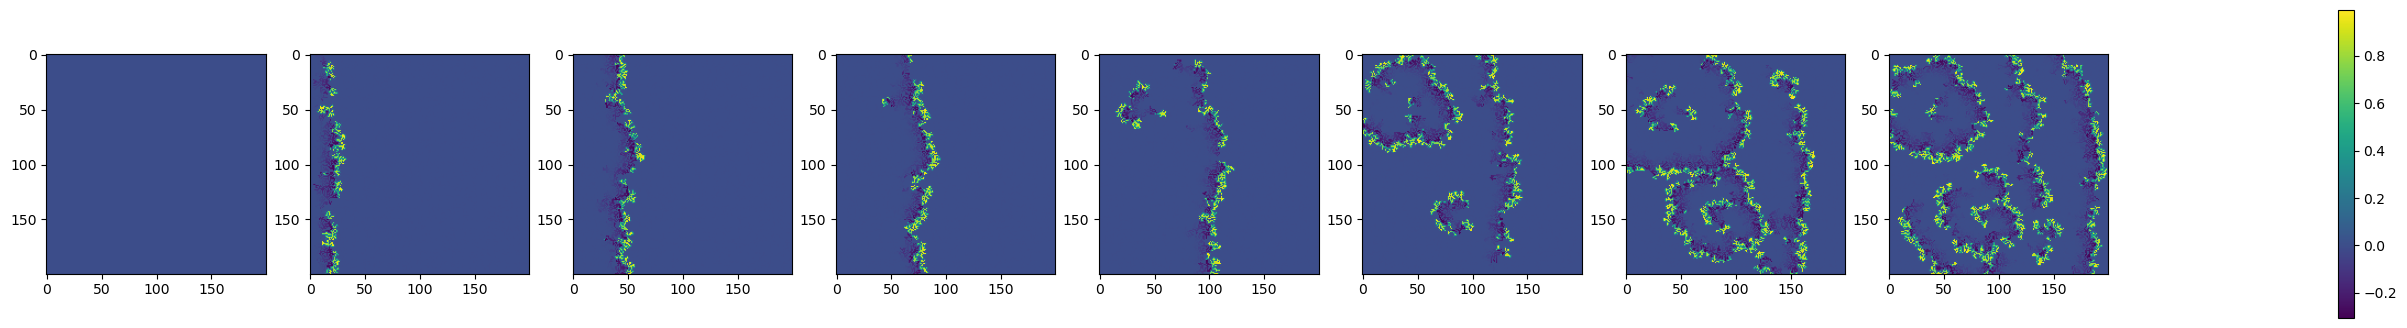

In [ ]:
u_sol, v_sol = run_simulation( N=N, L=L1, c1=c1)

fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol.min()
max = u_sol.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol[int((i/len(axs)*int(3000/0.25))),:].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

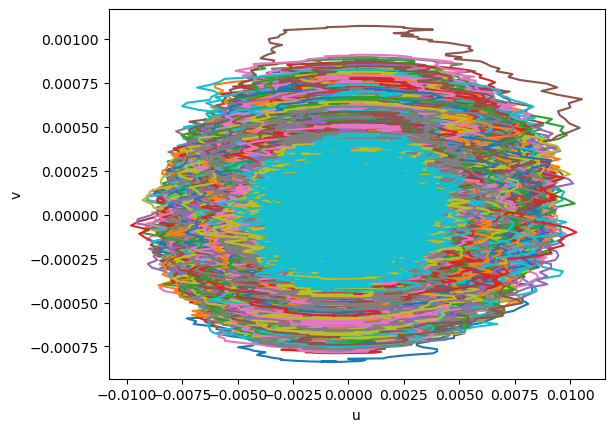

20010


In [61]:

c1 = c1.flatten()
u_sol=u_sol.T
v_sol=v_sol.T
##u_plot = np.array(u_sol[~c1, :])
#v_plot = np.array(v_sol[~c1, :])
u_plot = np.array(u_sol[c1, :])
v_plot = np.array(v_sol[c1, :])

# Plotting function
def plot_uv(u, v):
    plt.plot(u, v)  

# Plot each (u, v) pair for a subsample
#subsample_indices = np.random.choice(len(u_plot), size=100, replace=False)
for idx in range(len(u_plot)):
    plot_uv(u_plot[idx], v_plot[idx])

plt.xlabel('u')
plt.ylabel('v')
plt.show()
print(len(u_plot))

In [32]:

@jit
def calculate_entropy(power_spectrum):
    epsilon = 1e-12  # Small constant to prevent division by zero
    
    entropy = -jnp.sum(power_spectrum * jnp.log(power_spectrum + epsilon))  # Calculate entropy
    return jnp.abs(entropy)  # Ensure entropy is not negative


@jit
def process_element(array, i, j):
    fft_result_shifted = jnp.fft.fftshift(jnp.fft.fft(array[i, j, :]))  # FFT and shift in one line
    power_spectrum = jnp.abs(fft_result_shifted) ** 2
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    
    # Check if the power spectrum is normalized
    power_spectrum_sum = jnp.sum(power_spectrum)
    power_spectrum_normalized = jnp.allclose(power_spectrum_sum, 1.0, atol=1e-5)
    
    # Calculate entropy or return NaN if not normalized
    entropy = lax.cond(
        power_spectrum_normalized,
        lambda _: calculate_entropy(power_spectrum),
        lambda _: jnp.nan,
        operand=None
    )
    return entropy


def average_entropy(array, c1):
    N, M, T = array.shape
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M)))(jnp.arange(N))
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, vectorized_process)
    
    # Calculate the mean entropy, ignoring NaN values
    average_entropy = jnp.nanmean(masked_entropy)
    return average_entropy
'''
@jit
def process_element(array, i, j):
    fft_result = jnp.fft.fft(array[i, j, :])
    fft_result_shifted = jnp.fft.fftshift(fft_result)  # Shift the zero-frequency component to the center
    power_spectrum = jnp.abs(fft_result_shifted) ** 2
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    entropy = calculate_entropy(power_spectrum)
    return entropy

def average_entropy(array,c1):
    N, M, T = array.shape
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M)))(jnp.arange(N))
    
    #false_count = jnp.sum(c1 == False)

    # Create a mask for elements in array that are False in c1 and have 0 value for every t in T
    #zero_mask = (array == 0).all(axis=2)
    #false_count -= jnp.sum(zero_mask & ~c1)
    average_entropy = jnp.mean(vectorized_process)
    return average_entropy
'''

'\n@jit\ndef process_element(array, i, j):\n    fft_result = jnp.fft.fft(array[i, j, :])\n    fft_result_shifted = jnp.fft.fftshift(fft_result)  # Shift the zero-frequency component to the center\n    power_spectrum = jnp.abs(fft_result_shifted) ** 2\n    epsilon = 1e-12  # Small constant to prevent division by zero\n    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum\n    entropy = calculate_entropy(power_spectrum)\n    return entropy\n\ndef average_entropy(array,c1):\n    N, M, T = array.shape\n    \n    # Vectorized processing of all elements\n    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M)))(jnp.arange(N))\n    \n    #false_count = jnp.sum(c1 == False)\n\n    # Create a mask for elements in array that are False in c1 and have 0 value for every t in T\n    #zero_mask = (array == 0).all(axis=2)\n    #false_count -= jnp.sum(zero_mask & ~c1)\n    average_entropy = jnp.mean(vectorized_process)\n    return

In [ ]:
results_u = []
results_v=[]

# Loop over conduction threshold values
for conduction_threshold in jnp.arange(0, 0.9, 0.01):
    seed = int(conduction_threshold * 10)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold,sparse_matrix=True, seed=seed)
    
    u_sol, v_sol = run_simulation( N=N, L=L1, c1=c1,key=random.PRNGKey(seed))
    u_sol = u_sol.T
    v_sol = u_sol.T

    u_sol=u_sol.reshape(N_x, N_y,-1)
    v_sol=v_sol.reshape(N_x, N_y, -1)

    
    avg_entropy_u = average_entropy(u_sol, c1)
    avg_entropy_v = average_entropy(v_sol, c1)
    
    results_u.append( avg_entropy_u)
    results_v.append(avg_entropy_v)

results_u = jnp.array(results_u)
results_v = jnp.array(results_v)

In [ ]:
import jax.numpy as jnp
from jax import jit, vmap, lax

@jit
def calculate_entropy(power_spectrum):
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    entropy = -jnp.sum(power_spectrum * jnp.log(power_spectrum + epsilon))  # Calculate entropy
    return entropy

@jit
def process_element(array, i, j):
    fft_result_shifted = jnp.fft.fftshift(jnp.fft.fft(array[i, j, :]))  # FFT and shift in one line
    power_spectrum = jnp.abs(fft_result_shifted) ** 2
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    
    # Check if the power spectrum is normalized
    power_spectrum_sum = jnp.sum(power_spectrum)
    power_spectrum_normalized = jnp.allclose(power_spectrum_sum, 1.0, atol=1e-5)
    
    # Calculate entropy or return NaN if not normalized
    entropy = lax.cond(
        power_spectrum_normalized,
        lambda _: calculate_entropy(power_spectrum),
        lambda _: jnp.nan,
        operand=None
    )
    return entropy

def average_entropy(array, c1):
    N, M, T = array.shape
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M)))(jnp.arange(N))
    
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, vectorized_process)
    
    # Calculate the mean entropy, ignoring NaN values
    average_entropy = jnp.nanmean(masked_entropy)
    return average_entropy

# Example usage
N, M, T = 10, 10, 100  # Example dimensions
array = jnp.random.rand(N, M, T)  # Example array
c1 = jnp.zeros((N, M), dtype=bool)  # Example mask

avg_entropy = average_entropy(array, c1)
print(avg_entropy)

In [ ]:
import jax.numpy as jnp
from jax import jit, vmap, lax

@jit
def calculate_entropy(power_spectrum):
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    entropy = -jnp.sum(power_spectrum * jnp.log(power_spectrum + epsilon))  # Calculate entropy
    return entropy

@jit
def process_element(array, i, j):
    fft_result_shifted = jnp.fft.fftshift(jnp.fft.fft(array[i, j, :]))  # FFT and shift in one line
    power_spectrum = jnp.abs(fft_result_shifted) ** 2
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    
    # Check if the power spectrum is normalized
    power_spectrum_sum = jnp.sum(power_spectrum)
    power_spectrum_normalized = jnp.allclose(power_spectrum_sum, 1.0, atol=1e-5)
    
    # Calculate entropy or return NaN if not normalized
    entropy = lax.cond(
        power_spectrum_normalized,
        lambda _: calculate_entropy(power_spectrum),
        lambda _: jnp.nan,
        operand=None
    )
    return entropy

def average_entropy(array, c1):
    N, M, T = array.shape
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M)))(jnp.arange(N))
    
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, vectorized_process)
    
    # Calculate the mean entropy, ignoring NaN values
    average_entropy = jnp.nanmean(masked_entropy)
    return average_entropy

# Example usage
N, M, T = 10, 10, 100  # Example dimensions
array = jnp.random.rand(N, M, T)  # Example array
c1 = jnp.zeros((N, M), dtype=bool)  # Example mask

avg_entropy = average_entropy(array, c1)
print(avg_entropy)

65 44
89 0


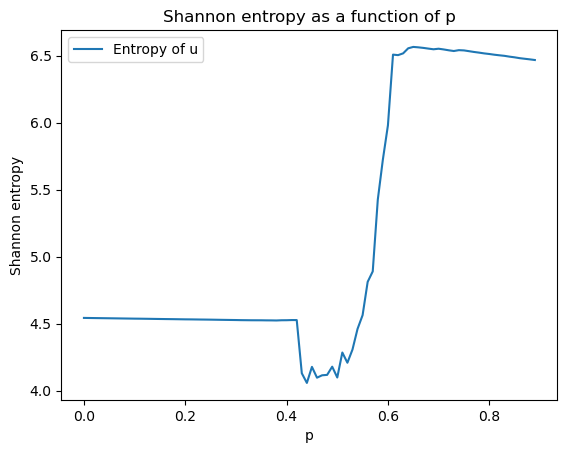

In [ ]:

print(np.argmax(results_u), np.argmin(results_u))
print(np.argmax(results_v), np.argmin(results_v))
plt.plot(np.arange(0,0.90,0.01),results_u,label='Entropy of u')
#plt.plot(np.arange(0,0.90,0.01),results_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Shannon entropy')
plt.legend()
plt.title('Shannon entropy as a function of p')
plt.show()

In [ ]:
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0,sparse_matrix=True, seed=2)
u_sol0, v_sol0 = run_simulation( N=N, L=L1, c1=c1,key=random.PRNGKey(seed))
u_sol0 = u_sol0.T
v_sol0 = u_sol0.T


In [70]:
power_values0 = jnp.abs(jnp.fft.fftshift(u_sol0[20000,:])) ** 2
power_values0=power_values0/np.sum(power_values0)
ent0=calculate_entropy(power_values0)

In [71]:
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.3,sparse_matrix=True, seed=2)
u_sol1, v_sol1 = run_simulation( N=N, L=L1, c1=c1,key=random.PRNGKey(seed))
u_sol1 = u_sol1.T
v_sol1 = u_sol1.T


In [74]:
power_values1 = jnp.abs(jnp.fft.fftshift(u_sol1[20000,:])) ** 2
power_values1=power_values1/np.sum(power_values1)
ent1=calculate_entropy(power_values1)

In [72]:
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.5,sparse_matrix=True, seed=2)
u_sol2, v_sol2 = run_simulation( N=N, L=L1, c1=c1,key=random.PRNGKey(seed))
u_sol2 = u_sol2.T
v_sol2 = u_sol2.T


In [75]:
power_values2 = jnp.abs(jnp.fft.fftshift(u_sol2[20000,:])) ** 2
power_values2=power_values2/np.sum(power_values2)
ent2=calculate_entropy(power_values2)

In [73]:
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.6,sparse_matrix=True, seed=2)
u_sol3, v_sol3 = run_simulation( N=N, L=L1, c1=c1,key=random.PRNGKey(seed))
u_sol3 = u_sol3.T
v_sol3 = u_sol3.T


In [76]:
power_values3 = jnp.abs(jnp.fft.fftshift(u_sol3[20000,:])) ** 2
power_values3=power_values3/np.sum(power_values3)
ent3=calculate_entropy(power_values3)

In [82]:
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.9,sparse_matrix=True, seed=2)
u_sol4, v_sol4 = run_simulation( N=N, L=L1, c1=c1,key=random.PRNGKey(seed))
u_sol4 = u_sol4.T
v_sol4 = v_sol4.T


In [83]:
power_values4 = jnp.abs(jnp.fft.fftshift(u_sol4[20000,:])) ** 2
power_values4=power_values4/np.sum(power_values4)
ent4=calculate_entropy(power_values4)

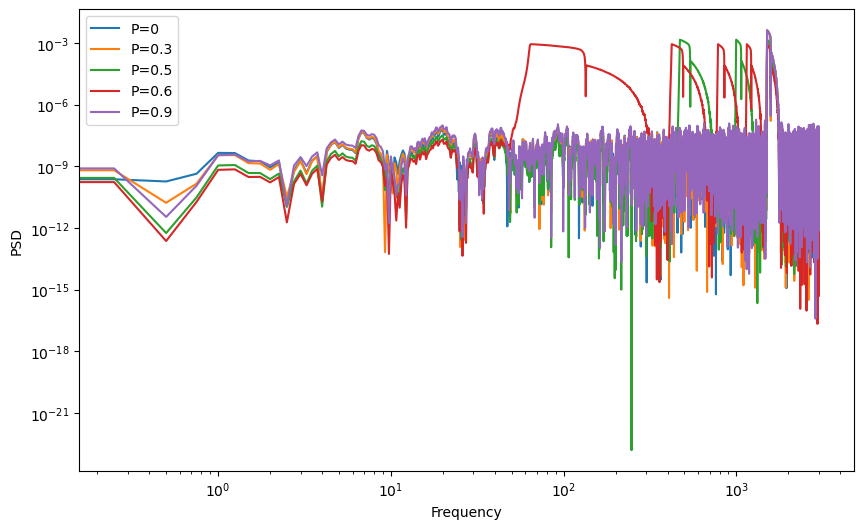

In [85]:
dts=int(3000/0.25)
plt.figure(figsize=(10, 6))
plt.loglog(np.linspace(0,3000,dts),power_values0, label='P=0')
plt.plot(np.linspace(0,3000,dts),power_values1, label='P=0.3')
plt.plot(np.linspace(0,3000,dts),power_values2, label='P=0.5')
plt.plot(np.linspace(0,3000,dts),power_values3, label='P=0.6')

plt.plot(np.linspace(0,3000,dts),power_values4, label='P=0.9')
plt.xlabel('Frequency')
plt.ylabel('PSD')
#plt.title('u(t)')
plt.legend()
#plt.grid(True)

plt.show()

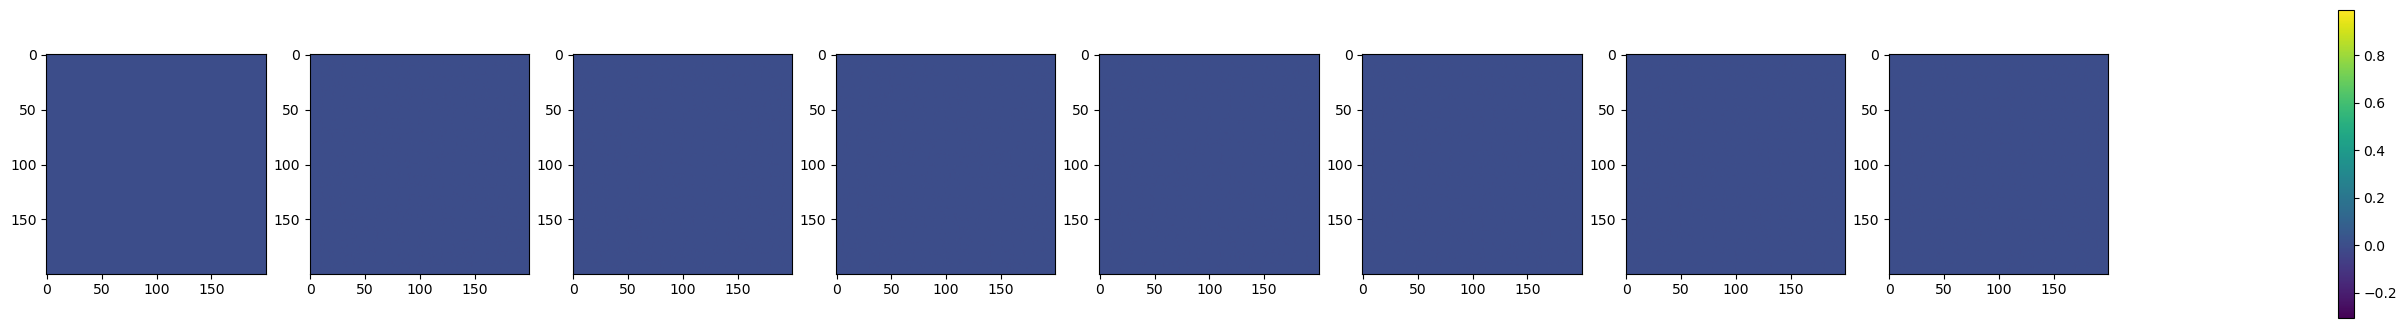

In [87]:
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol4.min()
max = u_sol4.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol4[:,int((i/len(axs)*int(3000/0.25)))].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])